In [1]:
from model.MultiResUNet3D import MultiResUnet3D
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programas\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

In [3]:
root_mask_path = "Y:/LIDC-IDRI_final_masks/LIDC-IDRI-{}.npz"

In [4]:
n_classes = 2
chanels = 1
mask_size = np.array([64, 64, 64])

In [2]:
import pydicom
from multiprocessing.pool import ThreadPool
import numpy as np
from glob import glob
import re

In [6]:
def get_coods_matrix(start, stop):

    z = np.arange(start[0], stop[0], 64)
    z[len(z) - 1] = stop[0] - 64

    y = np.arange(start[1], stop[1], 64)
    y[len(y) - 1] = stop[1] - 64

    x = np.arange(start[2], stop[2], 64)
    x[len(x) - 1] = stop[2] - 64

    indexes = np.array(np.meshgrid(z, y, x))
    indexes = indexes.reshape(3, -1).T

    return indexes

def index_to_slice(start, thickness):
    slices = []
    for i in start:
        t = slice(i, i + thickness)
        slices.append(t)
    return slices

def normalize(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray = np.clip(npzarray, 0, 1)
    return npzarray

In [7]:
def get_dicoms_from_folder(folder_name, jobs=30):
    try:
        list_url = glob(folder_name)
        dcms = list(ThreadPool(jobs).imap_unordered(pydicom.dcmread, list_url))
    except Exception as e:
        raise Exception('error al paralelizar la descarga ' + str(e))
    return dcms

def get_vol_from_dcms(dcms):
    dcms.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        vol = []
        spacing = np.array(dcms[0].PixelSpacing).astype(np.float)
        thickness = float(abs(dcms[0].ImagePositionPatient[2] - dcms[1].ImagePositionPatient[2]))
        spacing = np.concatenate([[thickness], spacing])

        for dcm in dcms:
            intercept = int(dcm.RescaleIntercept)
            slope = int(dcm.RescaleSlope)
            img_2d = dcm.pixel_array.copy().astype(np.int16)
            if slope != 1:
                img_2d *= slope

            img_2d += intercept
            vol.append(img_2d)

        vol = np.array(vol, dtype=np.int16)
    except Exception as e:
        print(str(e))
        raise Exception('error extraer el volumen del dicom ' + str(e))
    return vol, spacing

def make_predictions_fom_vol(vol, indexes):
    try:
        thickness = 64
        pred = np.zeros((*vol.shape, 2))
        for start in indexes:
            slices = index_to_slice(start, thickness)
            cube = vol[slices]
            temp = model_nodules_ct.predict(cube[np.newaxis, ..., np.newaxis]) # *cube.shape, 1
            pred[slices] = temp[0]
    except Exception as e:
        print(str(e))
        raise('error al hacer una de las predicciones de los nodulos' + str(e))
    return pred

In [3]:
train, test = np.load('splited.npy', allow_pickle=True)

In [4]:
path = test[20]

In [10]:
dcms = get_dicoms_from_folder(path+'/*.dcm')
vol, spacing = get_vol_from_dcms(dcms)
case = re.search('LIDC-IDRI-(.+?)/', path).group(1)

In [11]:
mask_path = root_mask_path.format(case)

file = np.load(mask_path)
mask = file['mask']
file.close()

In [12]:
start = (0, 0, 0)
stop = vol.shape
indexes = get_coods_matrix(start, stop)

In [13]:
model_nodules_ct = MultiResUnet3D(mask_size[0], mask_size[1], mask_size[2], chanels, n_classes)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model_nodules_ct.load_weights('./weights/weights.08.hdf5')

In [20]:
pred = make_predictions_fom_vol(normalize(vol), indexes)

D:\Programas\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
D:\Programas\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [21]:
temp = pred.argmax(-1)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib

def plot_vol(vol):
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)

    ax.imshow(vol[0], cmap="rainbow", vmax=1, vmin=0)

    axslides  = plt.axes([0.25, 0.15, 0.65, 0.03])
    sfreq = Slider(axslides, 'image_n', 0, len(vol)-1, valstep=1)

    def update(val):
        ax.imshow(vol[int(sfreq.val)], cmap="rainbow", vmax=1, vmin=0)
        fig.canvas.draw_idle()

    sfreq.on_changed(update)
    
    return sfreq

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


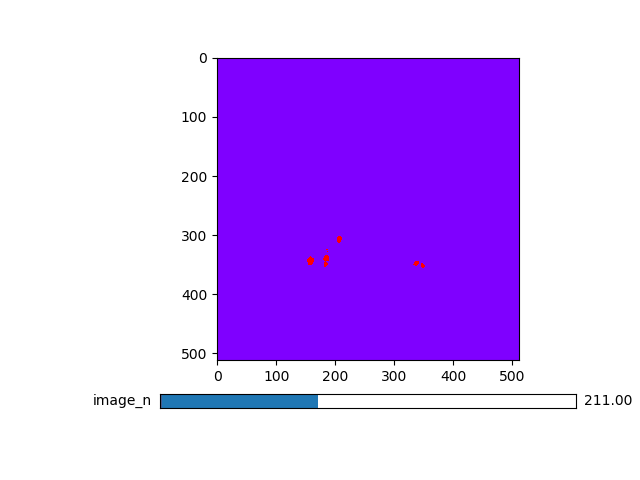

In [24]:
plot_vol(temp)

In [28]:
inter = temp * mask

In [29]:
inter.max()

1

In [30]:
np.where(inter.max(axis=1).max(axis=1))

(array([160, 161, 162, 163, 167, 209, 210, 211, 212, 213, 214, 215, 216,
        217, 218, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308],
       dtype=int64),)

In [25]:
np.where(mask.max(axis=1).max(axis=1))

(array([157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
        215, 216, 217, 218, 219, 297, 298, 299, 300, 301, 302, 303, 304,
        305, 306, 307, 308, 386, 387, 388], dtype=int64),)

<IPython.core.display.Javascript object>


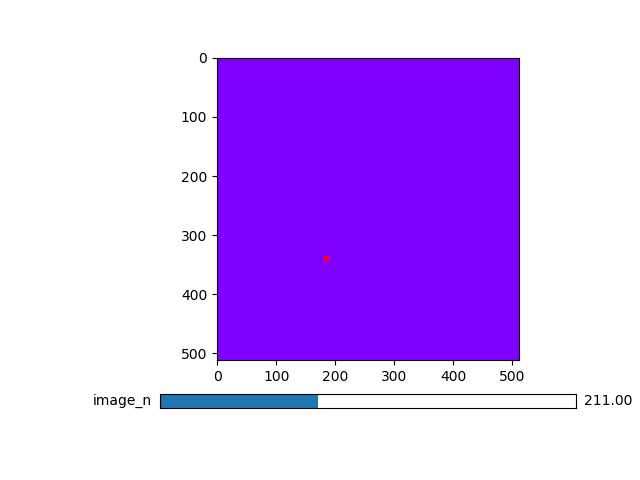

In [26]:
plot_vol(mask)